Поздравляем, вы приняли оффер в легендарном кластере BlackCircuit! На рассвете вас подхватила дрон-машина, провезла сквозь сверкающие высотки Нео-Токио, и высадила у входа в серверный бункер. На входе — биометрическая верификация, выдали плащ, терминал и доступ к внутренней сети.

Вы попали в отдел цифровой разведки — здесь мониторят весь городской эфир в поисках беспилотников-пришельцев. Коллеги уже развернули систему, которая улавливает сигнал и считывает параметры дрона. Ваша миссия — научить классификатор определять, относится ли объект к враждебной фракции или нет.

В репозитории лежат данные для обучения модели (‘train.csv‘) и отдельный датасет (‘test.csv‘), на котором нужно сделать предсказания.

Так как ошибка может стоить городу слишком дорого, точность модели должна быть не ниже 94%.

Ваша задача — залить в систему файл ‘answers.csv‘, где в каждой строке — 0 или 1 в зависимости от предсказания вашей модели.

Если точность ниже 94% — получите статус WA. Если всё круто — статус OK.

⚠ При отправке обязательно используйте компилятор yandexdataschool!

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import catboost as cb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)


from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score

In [41]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [42]:
# Посмотрим базу
print(f'Информация по трейну')
print(train.shape)
print(train.info())
train.head(5)

Информация по трейну
(1288, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           1288 non-null   int64  
 1   perimeter      1288 non-null   float64
 2   major_axis     1288 non-null   float64
 3   minor_axis     1288 non-null   float64
 4   eccentricity   1288 non-null   float64
 5   eqdiasq        1288 non-null   float64
 6   solidity       1288 non-null   float64
 7   convex_area    1288 non-null   int64  
 8   extent         1288 non-null   float64
 9   aspect_ratio   1288 non-null   float64
 10  roundness      1288 non-null   float64
 11  compactness    1288 non-null   float64
 12  shapefactor_1  1288 non-null   float64
 13  shapefactor_2  1288 non-null   float64
 14  shapefactor_3  1288 non-null   float64
 15  shapefactor_4  1288 non-null   float64
 16  target         1288 non-null   int64  
dtypes: float64(14), int6

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
0,75516,1731.4840,411.7352,245.7620,0.8023,310.0806,0.9148,82546,0.7169,1.6753,0.3165,0.7531,0.0055,0.0033,0.5672,0.9502,1
1,98903,1374.4370,477.2451,269.7676,0.8249,354.8622,0.9585,103181,0.7679,1.7691,0.6579,0.7436,0.0048,0.0027,0.5529,0.9781,0
2,84746,1311.1570,482.7735,235.9040,0.8725,328.4843,0.9121,92914,0.7162,2.0465,0.6195,0.6804,0.0057,0.0028,0.4630,0.9474,1
3,98184,1463.1680,434.3769,292.6472,0.7390,353.5700,0.9543,102890,0.7316,1.4843,0.5763,0.8140,0.0044,0.0030,0.6625,0.9834,0
4,94170,1267.7271,440.1109,278.4162,0.7745,346.2672,0.9643,97656,0.6836,1.5808,0.7363,0.7868,0.0047,0.0030,0.6190,0.9785,0


In [43]:
print(f'Информация по тесту')
print(test.shape)
print(test.info())
test.head(5)

Информация по тесту
(430, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           430 non-null    int64  
 1   perimeter      430 non-null    float64
 2   major_axis     430 non-null    float64
 3   minor_axis     430 non-null    float64
 4   eccentricity   430 non-null    float64
 5   eqdiasq        430 non-null    float64
 6   solidity       430 non-null    float64
 7   convex_area    430 non-null    int64  
 8   extent         430 non-null    float64
 9   aspect_ratio   430 non-null    float64
 10  roundness      430 non-null    float64
 11  compactness    430 non-null    float64
 12  shapefactor_1  430 non-null    float64
 13  shapefactor_2  430 non-null    float64
 14  shapefactor_3  430 non-null    float64
 15  shapefactor_4  430 non-null    float64
dtypes: float64(14), int64(2)
memory usage: 53.9 KB
None


,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4
0,93313,1862.7260,447.1666,278.4893,0.7824,344.6880,0.9361,99678,0.7607,1.6057,0.3380,0.7708,0.0048,0.0030,0.5942,0.9541
1,78778,2159.5969,439.1004,240.0113,0.8374,316.7069,0.9340,84345,0.7265,1.8295,0.2123,0.7213,0.0056,0.0030,0.5202,0.9517
2,74757,1661.6720,441.6910,225.3914,0.8600,308.5183,0.9359,79873,0.7255,1.9597,0.3402,0.6985,0.0059,0.0030,0.4879,0.9561
3,88074,2199.8889,460.8836,283.3717,0.7886,334.8721,0.8709,101133,0.6922,1.6264,0.2287,0.7266,0.0052,0.0032,0.5279,0.8586
4,79318,2589.4900,429.3032,279.5817,0.7589,317.7905,0.8666,91528,0.6634,1.5355,0.1486,0.7402,0.0054,0.0035,0.5480,0.8414


In [44]:
# Присутствует небольшой дисбаланс
train['target'].value_counts()

target
1    737
0    551
Name: count, dtype: int64

Я думаю париться особо не стоит. самое простое, что надо сделать:
- Немного предобработать фичульки
- Закинуть в catboost (предварительно настроив его гиперпараметры, не думаю, что придется их перебирать)
- Наслаждаться успехом
- Безусловно можно использовать логрегрессию и т.д., но мне лень обрабатывать фичульки)

In [45]:
# пропусков нет, ничо нет, балдеж!)
train.isnull().sum()

area             0
perimeter        0
major_axis       0
minor_axis       0
eccentricity     0
eqdiasq          0
solidity         0
convex_area      0
extent           0
aspect_ratio     0
roundness        0
compactness      0
shapefactor_1    0
shapefactor_2    0
shapefactor_3    0
shapefactor_4    0
target           0
dtype: int64

In [23]:
# Получим список фичей, исключая target
features = [col for col in train.columns if col != 'target']

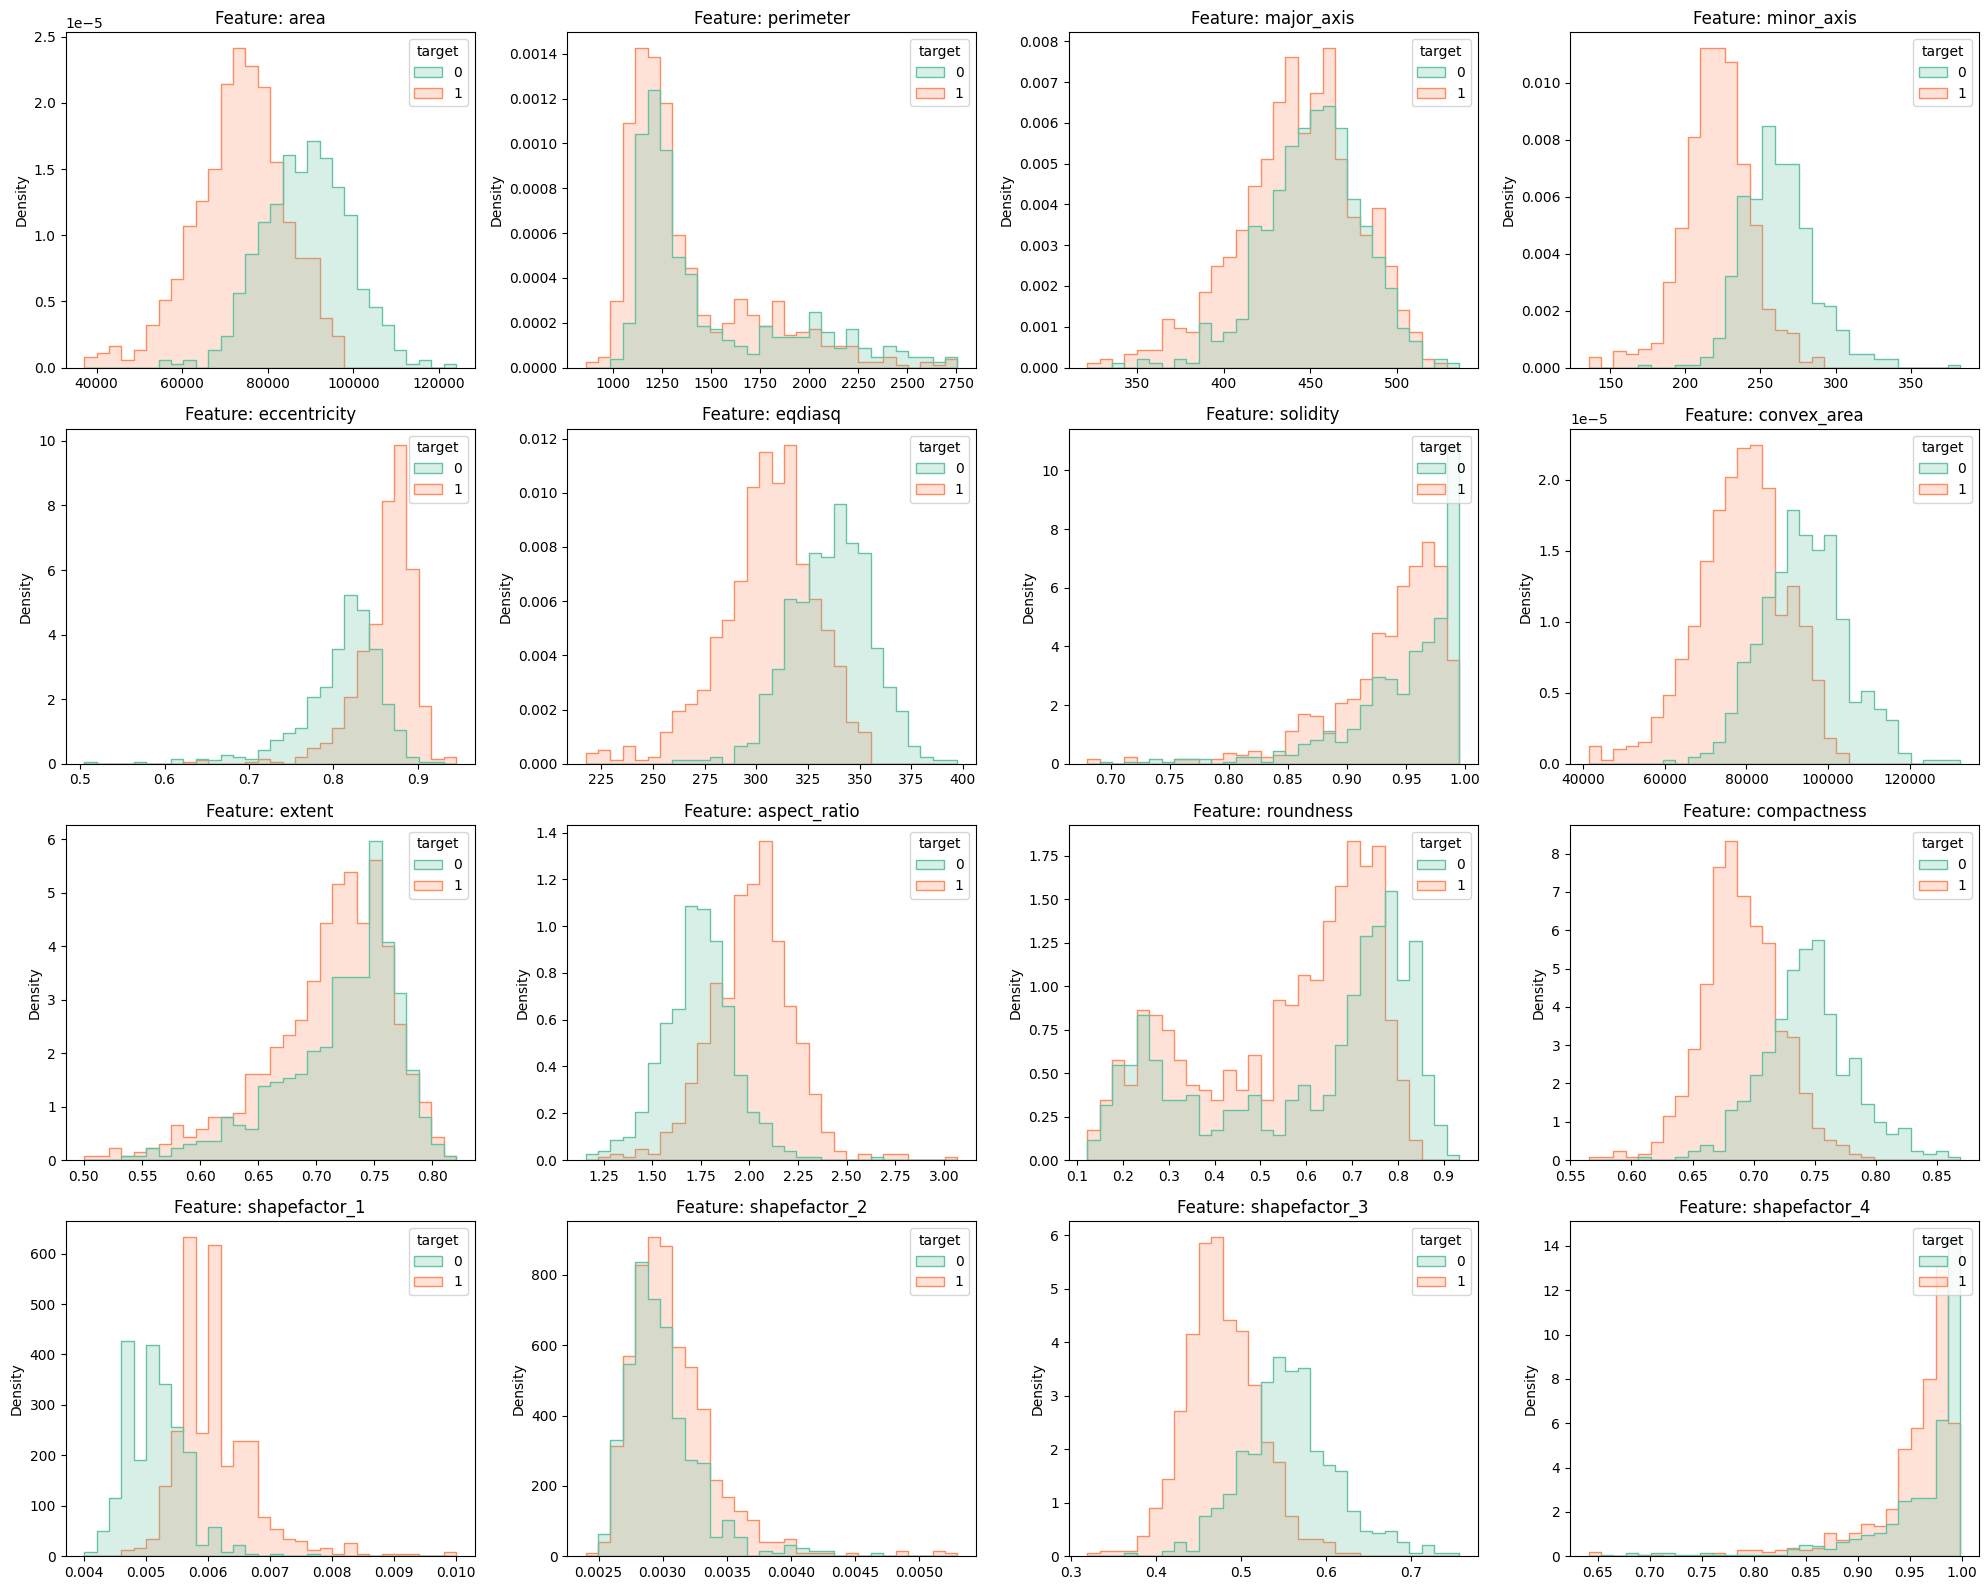

In [46]:
# Настроим размер полотна
num_features = len(features)
cols = 4  # Кол-во столбцов в сетке графиков
rows = (num_features + cols - 1) // cols  # Кол-во строк

plt.figure(figsize=(5 * cols, 4 * rows))
for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(data=train, x=feature, hue='target', bins=30, kde=False, palette='Set2', element='step', stat='density')
    plt.title(f'Feature: {feature}')
    plt.xlabel('')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

### **Фичи, хорошо разделяющие классы (`target 0` и `target 1`)**  
У этих признаков распределения двух классов визуально заметно различаются. Это может быть полезно для построения моделей:

1. **minor_axis** – класс 1 явно сдвинут влево относительно класса 0. Хорошо различимая разница.
2. **extent** – явное смещение у `target 1` вправо по сравнению с `target 0`.
3. **shape_factor_4** – видно, что у `target 1` чаще более высокие значения.
4. **roundness** – у `target 1` два пика, в отличие от более равномерного распределения у `target 0`.
5. **compactness** – распределения различаются и по центру, и по форме.
6. **eccentricity** – `target 1` более "вытянут", чем `target 0`, судя по сдвигу вправо.

---

### **Фичи с умеренными различиями**
Распределения пересекаются, но есть тенденции:

- **area / convex_area** – у `target 0` чуть больше объектов с меньшими значениями площади.
- **major_axis / aspect_ratio** – различия есть, но не резкие.
- **shape_factor_1 / shape_factor_3** – частичные различия, особенно на краях.

---

### **Фичи с похожими распределениями**
Могут иметь меньшую информативность:

- **solidity** – почти одинаковое распределение, различия неочевидны.
- **perimeter / eqdisaq** – распределения очень похожи.
- **shape_factor_2** – есть различия, но слабые и неустойчивые визуально.

---

Попробуем обучить катбустик на таких фичах, сразу бахнем регуляризацию, зададим веса для классов, ну и т.д.)

In [47]:
X = train.drop('target', inplace=False, axis=1)
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
model = CatBoostClassifier(verbose=False, 
                           random_seed=42,
                           auto_class_weights="Balanced",
                           eval_metric='Accuracy',
                           l2_leaf_reg=5,
                           iterations=100,
                           learning_rate=0.05,
                           depth=6,
                           early_stopping_rounds=30
                        )

# обучаем
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Предсказания
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Для ROC AUC нужно вероятности класса 1

# Метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report_str = classification_report(y_test, y_pred, digits=4)

# Вывод
print(f"Evaluation Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC AUC   : {roc_auc:.4f}")
# Красиво печатаем с заголовком
print("Отчет о классификации на валидационных данных:\n")
print(report_str)


Evaluation Metrics:
Accuracy  : 0.8643
Precision : 0.8849
Recall    : 0.8662
F1-score  : 0.8754
ROC AUC   : 0.9221
Отчет о классификации на валидационных данных:

              precision    recall  f1-score   support

           0     0.8403    0.8621    0.8511       116
           1     0.8849    0.8662    0.8754       142

    accuracy                         0.8643       258
   macro avg     0.8626    0.8641    0.8633       258
weighted avg     0.8649    0.8643    0.8645       258



In [17]:
# Предсказания на тестовой выборке (без y, если он недоступен)
y_test_pred = model.predict(test)

# Генерируем DataFrame с предсказаниями
submission = pd.DataFrame({'target': y_test_pred})

# Сохраняем в файл
submission.to_csv('answers.csv', index=False, header='')

print("✅ Файл answers.csv успешно создан!")


✅ Файл answers.csv успешно создан!


In [56]:
# Катбуст совместим с GridSearchCV без проблем
model = CatBoostClassifier(
    verbose=False,
    random_seed=42,
    auto_class_weights="Balanced"
)

# Сетка параметров
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 5, 10],
    'iterations': [100, 200]
}

# Скора по Precision
scorer = make_scorer(precision_score)

# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Поиск по сетке
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1  # параллельное обучение
)

# Запуск
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("🔍 Лучшие параметры:")
print(grid_search.best_params_)

# Обучаем финальную модель на лучших параметрах
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=30)

# Предсказания
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report_str = classification_report(y_test, y_pred, digits=4)

# Вывод
print(f"\n✅ Evaluation Metrics с GridSearchCV:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC AUC   : {roc_auc:.4f}")
print("\nОтчет о классификации на валидационных данных:\n")
print(report_str)

🔍 Лучшие параметры:
{'depth': 4, 'iterations': 100, 'l2_leaf_reg': 10, 'learning_rate': 0.1}

✅ Evaluation Metrics с GridSearchCV:
Accuracy  : 0.8566
Precision : 0.8671
Recall    : 0.8732
F1-score  : 0.8702
ROC AUC   : 0.9333

Отчет о классификации на валидационных данных:

              precision    recall  f1-score   support

           0     0.8435    0.8362    0.8398       116
           1     0.8671    0.8732    0.8702       142

    accuracy                         0.8566       258
   macro avg     0.8553    0.8547    0.8550       258
weighted avg     0.8565    0.8566    0.8565       258

